In [2]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sqlalchemy import create_engine


In [3]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [4]:
project_path = config["PATH"]["project"]
os.chdir(project_path)

Create spark session. Add driver postgress to enable to load from existing postgres DB


In [5]:
# add driver postgress to enable to load from existing postgres DB
spark = SparkSession \
    .builder \
    .appName("US_weather") \
    .config("spark.jars", "postgresql-42.2.18.jar")\
    .config( "spark.driver.extraClassPath", "postgresql-42.2.18.jar")\
    .getOrCreate()

Connect to postgres; read stations table from postgres DB "covid"

# Load data

## Read US stations from sql DB (including unincorporated territories)

In [6]:
# Puerto Rico, Virgin Islands, Guam, Samoa
unincorporated_territories = ["RQ", "VQ", "CQ", "AQ"]
US_territories = unincorporated_territories[:]
US_territories.append("US")

In [6]:
%%time
# Load weather stations for the whole world
engine = create_engine('postgresql://sb:sb@localhost:5432/covid')
world_stations = pd.read_sql_table("world_stations", engine)

CPU times: user 606 ms, sys: 74.9 ms, total: 681 ms
Wall time: 1.35 s


In [7]:
world_stations

,station_id,latitude,longitude,elevation,state,station_name
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP GSN 41196
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL 41194
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL 41217
...,...,...,...,...,...,...
118487,ZI000067969,21.0500,29.3670,861.0,,WEST NICHOLSON 67969
118488,ZI000067975,20.0670,30.8670,1095.0,,MASVINGO 67975
118489,ZI000067977,21.0170,31.5830,430.0,,BUFFALO RANGE 67977
118490,ZI000067983,20.2000,32.6160,1132.0,,CHIPINGE GSN 67983


In [8]:
US_stations = world_stations[ world_stations["station_id"].str[0:2].isin(US_territories) ].copy()
US_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65478 entries, 225 to 118159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_id    65478 non-null  object 
 1   latitude      65478 non-null  float64
 2   longitude     65478 non-null  float64
 3   elevation     65478 non-null  float64
 4   state         65478 non-null  object 
 5   station_name  65478 non-null  object 
dtypes: float64(3), object(3)
memory usage: 3.5+ MB


## Load filtered US weather stations

Only the stations yielding a valid measurement almost each day of 2020 are loaded.

In [9]:
df_filtered_stations = pd.read_csv("significant_stations.csv", index_col = 0)

In [10]:
df_filtered_stations.head()

,station_id,measured,nb_days
0,US1MDHW0007,PRCP,366
1,US1MNSE0002,PRCP,366
2,USW00014820,TAVG,366
3,USR0000CROC,TMIN,366
4,USC00132638,SNOW,355


In [11]:
df_filtered_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32814 entries, 0 to 32813
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   station_id  32814 non-null  object
 1   measured    32814 non-null  object
 2   nb_days     32814 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


# Find closest station to fips

In [12]:
def precompute_distance(l_ref):
    ''' 
    convert latitude and longitude to radian, and compute cos(latitude),
    which is necessary to compute the distance between any two GPS coordinates
    '''
    l_ref.rename(columns = {"latitude" : "latitude_degrees",
                           "longitude" : "longitude_degrees"
                          },
                inplace= True)
    def degree_to_radian(x):
        return  float(x)* np.pi / 180.
    l_ref["latitude_rad"] = l_ref["latitude_degrees"].apply( degree_to_radian) 
    l_ref["longitude_rad"] = l_ref["longitude_degrees"].apply( degree_to_radian)
    l_ref["cos_latitude"] = np.cos(l_ref["latitude_rad"])            

In [13]:
precompute_distance(US_stations)

For each element, list of the stations which give the element

In [14]:
l_measurements= ["SNOW", "SNWD", "PRCP", "TMAX", "TMIN", "TAVG"]

In [15]:
d_stations_per_element = {}
for element in l_measurements:
    d_stations_per_element[element] = pd.merge(
        df_filtered_stations[ df_filtered_stations["measured"] == element],
        US_stations, on = "station_id")\
        [ ["station_id", "latitude_rad", "longitude_rad", "cos_latitude"]].drop_duplicates()

In [16]:
for element, lst in d_stations_per_element.items():
    print(element, len(lst))

SNOW 3505
SNWD 3931
PRCP 11740
TMAX 5730
TMIN 5686
TAVG 2222


In [17]:
d_stations_per_element["TMAX"].head()

,station_id,latitude_rad,longitude_rad,cos_latitude
0,USW00024048,0.776966,-1.886390,0.713044
1,USW00094274,0.824974,-2.139357,0.678576
2,USS0005K27S,0.692198,-1.842893,0.769845
3,USS0045L01S,1.056797,-2.543817,0.491664
4,USC00339220,0.688038,-1.462973,0.772493


## Load NYTimes locations with geographic coordinates

In [18]:
data_root = os.path.join(project_path, 'OUT_DATA/')

In [19]:
nyt_locations= pd.read_csv( os.path.join(data_root, "nytimes_locations_lat_long.csv"))
print("number of location : ", len(nyt_locations))

number of location :  3270


In [20]:
precompute_distance(nyt_locations)

In [21]:
nyt_locations.head()

,Unnamed: 0,state,county,fips,latitude_degrees,longitude_degrees,latitude_rad,longitude_rad,cos_latitude
0,0,Washington,Snohomish,53061.0,48.054913,-121.765038,0.838716,-2.125201,0.668418
1,1,Illinois,Cook,17031.0,41.894294,-87.645455,0.731193,-1.529702,0.744378
2,2,California,Orange,6059.0,33.675687,-117.777207,0.587752,-2.055600,0.832189
3,3,Arizona,Maricopa,4013.0,33.345176,-112.498930,0.581983,-1.963477,0.835374
4,4,California,Los Angeles,6037.0,34.196398,-118.261862,0.596840,-2.064059,0.827116


In [22]:
def closest_ref(l_ref, latitude, longitude, cos_latitude):
        ''' computation of angular distance between 2 locations given by GPS coordinates
        exact formulas (maybe overkill), taken from :
        https://www.movable-type.co.uk/scripts/latlong.html
        '''    
        # Haversine formula
        #print(l_ref.head())
        l_ref["delta_lat_term"] = ( np.sin( (l_ref["latitude_rad"] - latitude) * 0.5 ) )**2
        l_ref["delta_long_term"] = ( np.sin( (l_ref["longitude_rad"] - longitude) * 0.5) )**2
        l_ref["a"] = l_ref["delta_lat_term"] + l_ref["delta_long_term"] \
                        * cos_latitude * l_ref["cos_latitude"]
        l_ref["sqrt_a"] = l_ref["a"].apply( lambda x : np.sqrt(x) )
        l_ref["sqrt_1_a"] = l_ref["a"].apply(lambda x : np.sqrt(1.- x) )
        l_ref["angle"] = np.arctan2( np.sqrt(l_ref["a"]), np.sqrt( 1. - l_ref["a"] ) )
        closest = l_ref["angle"].idxmin()
        #print(closest)
        return closest, l_ref.iloc[closest]

In [23]:
import functools

In [24]:
def func_closest_station( df_row, df_stations):
    i, res = closest_ref( df_stations, df_row["latitude_rad"], df_row["longitude_rad"], df_row["cos_latitude"] )
    return res.loc[["station_id", "latitude_rad", "longitude_rad", "angle"]]

In [25]:
R_earth = 6371

!! approximately 11 min to complete

In [26]:
closeststation_per_element ={}
for element in l_measurements:
    element_function = functools.partial(func_closest_station, df_stations=d_stations_per_element[element])
    %time res = nyt_locations.apply(element_function, axis = 1)
    res["distance"] = R_earth * res["angle"]
    closeststation_per_element[element] = pd.concat( [ res, nyt_locations[ ["fips", "state", "county"] ]], axis = 1)


CPU times: user 1min 23s, sys: 335 ms, total: 1min 23s
Wall time: 1min 23s
CPU times: user 1min 44s, sys: 527 ms, total: 1min 44s
Wall time: 1min 45s
CPU times: user 3min 39s, sys: 424 ms, total: 3min 40s
Wall time: 3min 40s
CPU times: user 2min 9s, sys: 432 ms, total: 2min 9s
Wall time: 2min 9s
CPU times: user 2min 4s, sys: 116 ms, total: 2min 4s
Wall time: 2min 4s
CPU times: user 1min 3s, sys: 56 ms, total: 1min 3s
Wall time: 1min 3s


## Checks

In [27]:
closeststation_per_element["PRCP"].head()

,station_id,latitude_rad,longitude_rad,angle,distance,fips,state,county
0,US1WASN0091,0.838870,-2.130305,0.001708,10.878616,53061.0,Washington,Snohomish
1,US1ILCK0074,0.731401,-1.532083,0.000892,5.684991,17031.0,Illinois,Cook
2,USC00044303,0.588525,-2.054656,0.000551,3.511917,6059.0,California,Orange
3,US1AZMR0170,0.583055,-1.962597,0.000650,4.140580,4013.0,Arizona,Maricopa
4,US1CALA0001,0.596360,-2.064632,0.000337,2.149035,6037.0,California,Los Angeles


In [28]:
for e, l  in closeststation_per_element.items():
    #print(e, len(l), l["distance"].min(), l["distance"].max(), l["distance"].mean())
    print(e, len(l), l["distance"].describe())

SNOW 3270 count    3270.000000
mean       39.104982
std       167.015503
min         0.034007
25%         4.992082
50%        10.530078
75%        18.543485
max      2989.364868
Name: distance, dtype: float64
SNWD 3270 count    3270.000000
mean       39.894647
std       167.911301
min         0.034007
25%         5.132098
50%        10.698195
75%        18.837340
max      2989.364868
Name: distance, dtype: float64
PRCP 3270 count    3270.000000
mean        6.954264
std        10.158977
min         0.034007
25%         2.734002
50%         5.012917
75%         9.171539
max       467.782916
Name: distance, dtype: float64
TMAX 3270 count    3270.000000
mean        9.316884
std        10.501826
min         0.034007
25%         3.889294
50%         7.491808
75%        13.014458
max       467.782916
Name: distance, dtype: float64
TMIN 3270 count    3270.000000
mean        9.358852
std        10.506962
min         0.034007
25%         3.924430
50%         7.599904
75%        13.095829
max    

## Output

In [29]:
closest_stations_allinfo ={} 
for element, l_stations in closeststation_per_element.items():
    closest_stations_allinfo[element] = pd.merge( l_stations, US_stations, on = "station_id")\
        .rename(columns = { "latitude_degrees" : "latitude_station", "longitude_degrees" : "longitude_station", 
                          "state_x" : "state_gazeeter", "state_y" : "state_station"})\
        [ ["fips",  "county", "state_gazeeter", 
           "station_id", "station_name", "state_station", "latitude_station", "longitude_station", "distance" ] ]

In [30]:
for element, l_stations in closest_stations_allinfo.items():
    out_name = os.path.join("OUT_DATA", f"closest_for_{element}.csv")
    l_stations.to_csv(out_name)
                    

In [31]:
# convert to multi index
dfmi_closest_stations = pd.concat(closest_stations_allinfo.values(), keys = closeststation_per_element.keys())

In [32]:
dfmi_closest_stations

fips                      county state_gazeeter   station_id  \
SNOW 0     53061.0                   Snohomish     Washington  USW00094290   
     1     17031.0                        Cook       Illinois  USC00111577   
     2      6059.0                      Orange     California  US1CALA0092   
     3      4013.0                    Maricopa        Arizona  USW00023183   
     4      6037.0                 Los Angeles     California  US1CALA0001   
...            ...                         ...            ...          ...   
TAVG 3265      NaN                     Unknown          Idaho  USR0000IHPK   
     3266      NaN                     Unknown        Montana  USS0009C01S   
     3267      NaN                     Unknown         Alaska  USR0000ANOR   
     3268      NaN                     Unknown        Wyoming  USS0007F06S   
     3269   2261.0  Valdez-Cordova Census Area         Alaska  USS0046M04S   

                                           station_name state_station  \
SNOW 0     SEATTLE SAND PT WSFO                                    WA   
     1     CHICAGO MIDWAY AP 3SW                  72534            IL   
     2     REDONDO BEACH 2.1 SSW                                   CA   
     3     PHOENIX SKY HARBOR INTL AP     GSN     72278            AZ   
     4     GLENDALE 2.4 WSW                                        CA   
...                                                 ...           ...   
TAVG 3265  HORTON PEAK IDAHO                                       ID   
     3266  Crystal Lake                                            MT   
     3267  NORUTAK LAKE ALASKA                                     AK   
     3268  Grave Springs                                           WY   
     3269  Sugarloaf Mtn                                           AK   

           latitude_station  longitude_station   distance  
SNOW 0              47.6872          -122.2553  27.427372  
     1              41.7372           -87.7775  10.306315  
     2              33.8274          -118.3888  29.503349  
     3              33.4278          -112.0039  23.435202  
     4              34.1689          -118.2947   2.149035  
...                     ...                ...        ...  
TAVG 3265           43.9481          -114.7561   6.701040  
     3266           46.7900          -109.5100   9.785520  
     3267           66.8333          -154.3333  43.082228  
     3268           43.4700          -107.2400  22.001426  
     3269           61.0800          -146.3000   3.169607  

[19620 rows x 9 columns]

In [1]:
out_name = os.path.join("OUT_DATA", "closest_stations.csv")
#closest_stations_allinfo = titi


NameError: name 'os' is not defined

In [35]:
dfmi_closest_stations.to_csv(out_name)

# Handle outliers

Identify fips which have been attributed to a wrong station.

In [6]:
# check multi index read ok 
out_name = os.path.join("OUT_DATA", "closest_stations.csv")
toto = pd.read_csv(out_name, index_col = [0,1])#, skipinitialspace=True)
toto

fips                      county state_gazeeter   station_id  \
SNOW 0     53061.0                   Snohomish     Washington  USW00094290   
     1     17031.0                        Cook       Illinois  USC00111577   
     2      6059.0                      Orange     California  US1CALA0092   
     3      4013.0                    Maricopa        Arizona  USW00023183   
     4      6037.0                 Los Angeles     California  US1CALA0001   
...            ...                         ...            ...          ...   
TAVG 3265      NaN                     Unknown          Idaho  USR0000IHPK   
     3266      NaN                     Unknown        Montana  USS0009C01S   
     3267      NaN                     Unknown         Alaska  USR0000ANOR   
     3268      NaN                     Unknown        Wyoming  USS0007F06S   
     3269   2261.0  Valdez-Cordova Census Area         Alaska  USS0046M04S   

                                           station_name state_station  \
SNOW 0     SEATTLE SAND PT WSFO                                    WA   
     1     CHICAGO MIDWAY AP 3SW                  72534            IL   
     2     REDONDO BEACH 2.1 SSW                                   CA   
     3     PHOENIX SKY HARBOR INTL AP     GSN     72278            AZ   
     4     GLENDALE 2.4 WSW                                        CA   
...                                                 ...           ...   
TAVG 3265  HORTON PEAK IDAHO                                       ID   
     3266  Crystal Lake                                            MT   
     3267  NORUTAK LAKE ALASKA                                     AK   
     3268  Grave Springs                                           WY   
     3269  Sugarloaf Mtn                                           AK   

           latitude_station  longitude_station   distance  
SNOW 0              47.6872          -122.2553  27.427372  
     1              41.7372           -87.7775  10.306315  
     2              33.8274          -118.3888  29.503349  
     3              33.4278          -112.0039  23.435202  
     4              34.1689          -118.2947   2.149035  
...                     ...                ...        ...  
TAVG 3265           43.9481          -114.7561   6.701040  
     3266           46.7900          -109.5100   9.785520  
     3267           66.8333          -154.3333  43.082228  
     3268           43.4700          -107.2400  22.001426  
     3269           61.0800          -146.3000   3.169607  

[19620 rows x 9 columns]

In [7]:
#titi = toto.groupby(level=0).apply(lambda toto: toto.xs(toto.name).to_dict()).to_dict()
# convert multiindex dataframe to dict

# all level 0 index values (i.e. weather elements)
l_weather_elements = toto.index.levels[0]
print(l_weather_elements)
# slice dataframe along elements and make put into dict

titi= { elem : toto.xs(elem) for elem in l_weather_elements }
titi["PRCP"].head()


Index(['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'], dtype='object')


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
0,53061.0,Snohomish,Washington,US1WASN0091,LAKE STEVENS 3.2 N,WA,48.0637,-122.0575,10.878616
1,17031.0,Cook,Illinois,US1ILCK0074,OAK PARK 1.3 NNE,IL,41.9062,-87.7819,5.684991
2,6059.0,Orange,California,USC00044303,IRVINE RCH,CA,33.7200,-117.7231,3.511917
3,4013.0,Maricopa,Arizona,US1AZMR0170,GOODYEAR 5.9 WSW,AZ,33.4066,-112.4485,4.140580
4,6037.0,Los Angeles,California,US1CALA0001,GLENDALE 2.4 WSW,CA,34.1689,-118.2947,2.149035


In [8]:
for elem, lst in titi.items():
    print(elem, len(lst))

PRCP 3270
SNOW 3270
SNWD 3270
TAVG 3270
TMAX 3270
TMIN 3270


In [9]:
dfmi_closest_stations = toto
closest_stations_allinfo = titi

<AxesSubplot:>

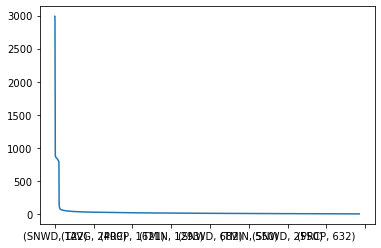

In [14]:
dfmi_closest_stations["distance"].sort_values(ascending = False).plot()

<AxesSubplot:>

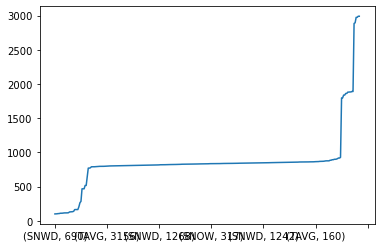

In [15]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 100]["distance"].sort_values().plot()

<AxesSubplot:>

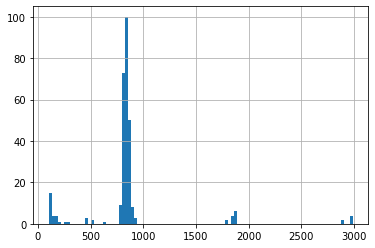

In [16]:
dfmi_closest_stations["distance"].where(dfmi_closest_stations["distance"]>100).hist(bins = 100)

<AxesSubplot:>

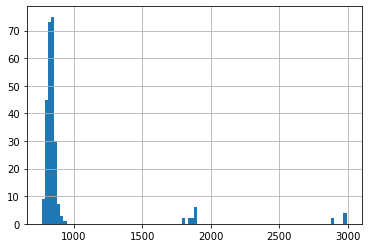

In [17]:
stations_further_700 = dfmi_closest_stations[ dfmi_closest_stations["distance"]> 700]
stations_further_700["distance"].hist(bins = 100)

In [18]:
stations_further_700.describe()

,fips,latitude_station,longitude_station,distance
count,259.000000,261.000000,261.000000,261.000000
mean,70011.077220,27.003106,-85.303100,930.850038
std,11108.639534,5.695128,18.723352,378.296411
min,15001.000000,22.130600,-166.543300,770.309777
25%,72033.000000,25.790600,-81.051700,816.247878
50%,72073.000000,25.790600,-80.316400,838.128486
75%,72117.000000,26.071900,-80.197900,855.666661
max,78030.000000,53.895000,-80.153600,2989.364868


In [36]:
stations_further_700[["state_gazeeter", "state_station"]]

state_gazeeter state_station
SNOW 95               HI            AK
     96               HI            AK
     97               HI            AK
     262              HI            CA
     263              HI            CA
...                  ...           ...
TAVG 3216             PR            FL
     3217             PR            FL
     3218             PR            FL
     3219             PR            FL
     3220             PR            FL

[244 rows x 2 columns]

In [37]:
stations_further_700["state_gazeeter"].value_counts()

PR    234
HI     10
Name: state_gazeeter, dtype: int64

In [38]:
stations_further_700["state_station"].value_counts()

FL    234
AK      6
CA      4
Name: state_station, dtype: int64

FIPS from Hawai and Puerto Rico are incorrectly matched because the list of stations with USxxx prefix does not contain unincorporated territories

In [39]:
gazeeter_counties[ gazeeter_counties["state"] == "HI"]

,state,county,fips,latitude_degrees,longitude_degrees,latitude_rad,longitude_rad,cos_latitude
547,HI,Hawaii County,15001,19.597764,-155.502443,0.342046,-2.714030,0.942071
548,HI,Honolulu County,15003,21.461365,-158.201974,0.374571,-2.761145,0.930664
549,HI,Kalawao County,15005,21.218764,-156.97401,0.370337,-2.739713,0.932205
550,HI,Kauai County,15007,22.012038,-159.705965,0.384183,-2.787395,0.927105
551,HI,Maui County,15009,20.855931,-156.60155,0.364005,-2.733213,0.934479


In [40]:
world_stations = pd.read_csv("DATA/WEATHER/ghcnd-stations_noname.txt", delim_whitespace = True, names = ["id", "latitude", "longitude", "elevation"])

In [41]:
world_stations.columns

Index(['id', 'latitude', 'longitude', 'elevation'], dtype='object')

In [42]:
world_stations.describe()

,latitude,longitude,elevation
count,118492.000000,118492.000000,118492.000000
mean,24.925502,-41.351049,449.471609
std,28.963270,91.205526,663.975681
min,-90.000000,-179.983000,-999.900000
25%,19.316700,-100.684350,84.000000
50%,36.505300,-84.079550,258.800000
75%,42.792200,11.517300,610.000000
max,83.650000,179.320000,5033.000000


In [43]:
hawai_longitude = ( -160.5, -154)
hawai_latitude = ( 18, 22.5)

In [44]:
stations_long_hawai = world_stations[ ( world_stations["longitude"]>-160.5 ) & ( world_stations["longitude"]< -154 )
                                    & ( world_stations["latitude"]>18 ) & ( world_stations["latitude"]< 22.5 ) ]

In [45]:
sorted( list(stations_long_hawai["id"]) )

['US1HIHI0001',
 'US1HIHI0002',
 'US1HIHI0003',
 'US1HIHI0004',
 'US1HIHI0006',
 'US1HIHI0008',
 'US1HIHI0010',
 'US1HIHI0011',
 'US1HIHI0012',
 'US1HIHI0013',
 'US1HIHI0014',
 'US1HIHI0015',
 'US1HIHI0016',
 'US1HIHI0017',
 'US1HIHI0019',
 'US1HIHI0020',
 'US1HIHI0021',
 'US1HIHI0022',
 'US1HIHI0024',
 'US1HIHI0026',
 'US1HIHI0031',
 'US1HIHI0033',
 'US1HIHI0034',
 'US1HIHI0035',
 'US1HIHI0036',
 'US1HIHI0037',
 'US1HIHI0038',
 'US1HIHI0039',
 'US1HIHI0040',
 'US1HIHI0041',
 'US1HIHI0042',
 'US1HIHI0043',
 'US1HIHI0045',
 'US1HIHI0047',
 'US1HIHI0049',
 'US1HIHI0050',
 'US1HIHI0051',
 'US1HIHI0052',
 'US1HIHI0053',
 'US1HIHI0055',
 'US1HIHI0056',
 'US1HIHI0057',
 'US1HIHI0059',
 'US1HIHI0060',
 'US1HIHI0065',
 'US1HIHI0066',
 'US1HIHI0067',
 'US1HIHI0068',
 'US1HIHI0070',
 'US1HIHI0071',
 'US1HIHI0072',
 'US1HIHI0074',
 'US1HIHI0079',
 'US1HIHI0080',
 'US1HIHI0081',
 'US1HIHI0082',
 'US1HIHI0083',
 'US1HIHI0084',
 'US1HIHI0086',
 'US1HIHI0087',
 'US1HIHI0088',
 'US1HIHN0002',
 'US1HIH

In [46]:
df_stations[ df_stations["station_id"] == "USW00022551" ]
#USR0000HKMO

NameError: name 'df_stations' is not defined

In [47]:
gazeeter_counties[ gazeeter_counties["state"] == "HI"]

,state,county,fips,latitude_degrees,longitude_degrees,latitude_rad,longitude_rad,cos_latitude
547,HI,Hawaii County,15001,19.597764,-155.502443,0.342046,-2.714030,0.942071
548,HI,Honolulu County,15003,21.461365,-158.201974,0.374571,-2.761145,0.930664
549,HI,Kalawao County,15005,21.218764,-156.97401,0.370337,-2.739713,0.932205
550,HI,Kauai County,15007,22.012038,-159.705965,0.384183,-2.787395,0.927105
551,HI,Maui County,15009,20.855931,-156.60155,0.364005,-2.733213,0.934479


In [48]:
stt = "USR0000HKMO"
df_stations[ df_stations["station_id"] == stt]

NameError: name 'df_stations' is not defined

In [49]:
stations_selected = pd.read_parquet("OUT_DATA/stations_selected-measures_ndays")

In [50]:
stations_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81991 entries, 0 to 81990
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   station_id  81991 non-null  object
 1   measured    81991 non-null  object
 2   nb_days     81991 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [51]:
stations_selected_hawaii = stations_selected[ stations_selected["station_id"].isin(list(stations_long_hawai["id"]) ) ]

In [52]:
stations_selected_hawaii

,station_id,measured,nb_days
71,USC00516928,PRCP,356
206,USC00513977,TMIN,145
227,USR0000HMLK,TMIN,366
334,USC00510470,TMIN,55
397,US1HIKI0019,PRCP,356
...,...,...,...
80952,USR0000HMAH,TMAX,366
80976,USC00516128,TMAX,361
81143,US1HIHN0027,SNOW,73
81298,USR0000HMAR,TMAX,355


In [53]:
stations_long_hawai.shape

(749, 4)

In [54]:
stations_selected_hawaii[ stations_selected_hawaii["nb_days"]>350]

,station_id,measured,nb_days
71,USC00516928,PRCP,356
227,USR0000HMLK,TMIN,366
397,US1HIKI0019,PRCP,356
1275,USW00021504,TAVG,366
1706,USR0000HPTA,TAVG,366
...,...,...,...
79441,USC00519523,TMIN,351
79810,USW00022516,TAVG,366
80952,USR0000HMAH,TMAX,366
80976,USC00516128,TMAX,361


In [55]:
df_filtered_stations[ df_filtered_stations["station_id"].isin(list(stations_long_hawai["id"]) )]

,station_id,measured,nb_days
38,USC00516928,PRCP,356
125,USR0000HMLK,TMIN,366
166,US1HIKI0019,PRCP,356
535,USW00021504,TAVG,366
729,USR0000HPTA,TAVG,366
...,...,...,...
31784,USC00519523,TMIN,351
31961,USW00022516,TAVG,366
32397,USR0000HMAH,TMAX,366
32415,USC00516128,TMAX,361


In [56]:
stations_selected_hawaii[ stations_selected_hawaii["nb_days"]>350].equals( df_filtered_stations[ df_filtered_stations["station_id"].isin(list(stations_long_hawai["id"]) )] )

False

In [57]:
stations_further_700[ stations_further_700["state_gazeeter"] == "HI"]

fips           county state_gazeeter   station_id  \
SNOW 95   15003  Honolulu County             HI  USC00502587   
     96   15005   Kalawao County             HI  USC00502587   
     97   15007     Kauai County             HI  USC00502587   
     262  15001    Hawaii County             HI  US1CASM0007   
     263  15009      Maui County             HI  US1CASM0007   
SNWD 91   15003  Honolulu County             HI  USC00502587   
     92   15005   Kalawao County             HI  USC00502587   
     93   15007     Kauai County             HI  USC00502587   
     257  15001    Hawaii County             HI  US1CASM0007   
     258  15009      Maui County             HI  US1CASM0007   

                                          station_name state_station  \
SNOW 95   DUTCH HARBOR                                            AK   
     96   DUTCH HARBOR                                            AK   
     97   DUTCH HARBOR                                            AK   
     262  HALF MOON BAY 0.5 SSW                                   CA   
     263  HALF MOON BAY 0.5 SSW                                   CA   
SNWD 91   DUTCH HARBOR                                            AK   
     92   DUTCH HARBOR                                            AK   
     93   DUTCH HARBOR                                            AK   
     257  HALF MOON BAY 0.5 SSW                                   CA   
     258  HALF MOON BAY 0.5 SSW                                   CA   

          latitude_station  longitude_station     distance  
SNOW 95             53.895          -166.5433  1837.397653  
     96             53.895          -166.5433  1861.329474  
     97             53.895          -166.5433  1795.907377  
     262            37.463          -122.4408  1880.790043  
     263            37.463          -122.4408  1883.043157  
SNWD 91             53.895          -166.5433  1837.397653  
     92             53.895          -166.5433  1861.329474  
     93             53.895          -166.5433  1795.907377  
     257            37.463          -122.4408  1880.790043  
     258            37.463          -122.4408  1883.043157

<font size=5>**Conclusion : No snow in Hawaii !! ;)**</font>

In [58]:
stations_further_700[ stations_further_700["state_gazeeter"] == "PR"]

fips                  county state_gazeeter   station_id  \
SNOW 425   72001      Adjuntas Municipio             PR  USW00012839   
     426   72003        Aguada Municipio             PR  USW00012839   
     427   72005     Aguadilla Municipio             PR  USW00012839   
     428   72007  Aguas Buenas Municipio             PR  USW00012839   
     429   72009      Aibonito Municipio             PR  USW00012839   
...          ...                     ...            ...          ...   
TAVG 3216  72133  Santa Isabel Municipio             PR  USW00012839   
     3217  72141        Utuado Municipio             PR  USW00012839   
     3218  72149      Villalba Municipio             PR  USW00012839   
     3219  72151       Yabucoa Municipio             PR  USW00012839   
     3220  72153         Yauco Municipio             PR  USW00012839   

                                           station_name state_station  \
SNOW 425   MIAMI INTL AP                          72202            FL   
     426   MIAMI INTL AP                          72202            FL   
     427   MIAMI INTL AP                          72202            FL   
     428   MIAMI INTL AP                          72202            FL   
     429   MIAMI INTL AP                          72202            FL   
...                                                 ...           ...   
TAVG 3216  MIAMI INTL AP                          72202            FL   
     3217  MIAMI INTL AP                          72202            FL   
     3218  MIAMI INTL AP                          72202            FL   
     3219  MIAMI INTL AP                          72202            FL   
     3220  MIAMI INTL AP                          72202            FL   

           latitude_station  longitude_station    distance  
SNOW 425            25.7906           -80.3164  816.178941  
     426            25.7906           -80.3164  791.410175  
     427            25.7906           -80.3164  790.049157  
     428            25.7906           -80.3164  841.812683  
     429            25.7906           -80.3164  839.538138  
...                     ...                ...         ...  
TAVG 3216           25.7906           -80.3164  839.529466  
     3217           25.7906           -80.3164  815.878703  
     3218           25.7906           -80.3164  830.342695  
     3219           25.7906           -80.3164  859.654377  
     3220           25.7906           -80.3164  814.772073  

[234 rows x 9 columns]

In [59]:
dfmi_closest_stations[dfmi_closest_stations["state_gazeeter"] == "PR"]["distance"].describe()

count    468.000000
mean     419.798072
std      413.446163
min        0.146478
25%        5.988331
50%      406.108779
75%      835.211650
max      885.650469
Name: distance, dtype: float64

In [60]:
stations_further_700[ stations_further_700["state_gazeeter"] == "PR"]["state_station"].value_counts()

FL    234
Name: state_station, dtype: int64

<font size=5>**Puerto Rico fips always maps to stations in Florida**</font>

In [65]:
a = df_stations[df_stations["station_id"].str.startswith("US")]
print(len(a), len(df_stations))

65170 65170


## Outliers in precipitations

In [19]:
closest_stations_allinfo["PRCP"].describe()

,fips,latitude_station,longitude_station,distance
count,3218.000000,3270.000000,3270.000000,3270.000000
mean,31471.421069,37.945618,-91.517638,6.954264
std,16368.839603,6.139814,14.680765,10.158977
min,1001.000000,15.116700,-170.211900,0.034007
25%,19035.500000,34.314575,-98.122900,2.734002
50%,30026.000000,38.220000,-89.948350,5.012917
75%,46118.500000,41.711625,-82.937175,9.171539
max,78030.000000,70.346400,145.749700,467.782916


In [21]:
closest_stations_allinfo["PRCP"].sort_values(by = "distance", ascending= False).head(10)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
3086,2016.0,Aleutians West Census Area,Alaska,USW00025711,ST. PAUL 4 NE 70309,AK,57.1575,-170.2119,467.782916
2537,2158.0,Kusilvak Census Area,Alaska,USW00026615,BETHEL AP GSN 70219,AK,60.7850,-161.8292,90.783556
3059,2185.0,North Slope Borough,Alaska,USC00500235,ALPINE,AK,70.3464,-150.9283,69.642501
3069,2070.0,Dillingham Census Area,Alaska,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
3254,NaN,Unknown,Alaska,USS0051R01S,Bettles Field,AK,66.9200,-151.5300,58.647599
3032,2188.0,Northwest Arctic Borough,Alaska,USW00026616,KOTZEBUE RALPH WEIN AP GSN 70133,AK,66.8667,-162.6333,57.409746
2494,2195.0,Petersburg Borough,Alaska,USC00503605,HIDDEN FALLS HATCHERY,AK,57.2178,-134.8770,56.626781
2536,2050.0,Bethel Census Area,Alaska,USW00026615,BETHEL AP GSN 70219,AK,60.7850,-161.8292,46.094564
127,22075.0,Plaquemines,Louisiana,US1LAOR0013,WESTWEGO 2.4 ENE,LA,29.9209,-90.1070,43.803054
44,32031.0,Washoe,Nevada,USC00267953,SUTCLIFFE,NV,39.9508,-119.5986,43.481374


<font size=4>**Large distances are mainly in Alaska**<font>

## Outliers in temperatures

### Outliers in min temperature

In [22]:
closest_stations_allinfo["TMIN"].describe()

,fips,latitude_station,longitude_station,distance
count,3218.000000,3270.000000,3270.000000,3270.000000
mean,31471.421069,37.945643,-91.520125,9.358852
std,16368.839603,6.136440,14.687555,10.506962
min,1001.000000,15.116700,-170.211900,0.034007
25%,19035.500000,34.357400,-98.083300,3.924430
50%,30026.000000,38.202200,-90.000000,7.599904
75%,46118.500000,41.738425,-82.925425,13.095829
max,78030.000000,69.370000,145.749700,467.782916


In [23]:
closest_stations_allinfo["TMIN"].sort_values(by = "distance", ascending= False).head(10)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
3112,2016.0,Aleutians West Census Area,Alaska,USW00025711,ST. PAUL 4 NE 70309,AK,57.1575,-170.2119,467.782916
3098,2070.0,Dillingham Census Area,Alaska,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
3174,2158.0,Kusilvak Census Area,Alaska,USW00026656,BETHEL 87 WNW,AK,61.3464,-164.0770,57.071373
158,22075.0,Plaquemines,Louisiana,USW00012916,NEW ORLEANS INTL AP GSN 72231,LA,29.9933,-90.2511,51.244409
2611,2195.0,Petersburg Borough,Alaska,USR0000AZAR,ZAREMBO ALASKA,AK,56.3000,-132.8486,45.433733
3260,NaN,Unknown,Alaska,USR0000ANOR,NORUTAK LAKE ALASKA,AK,66.8333,-154.3333,43.082228
2823,2150.0,Kodiak Island Borough,Alaska,USW00025501,KODIAK AP 70350,AK,57.7511,-152.4856,42.611458
2956,72097.0,Mayaguez,Puerto Rico,RQC00662801,COLOSO,PR,18.3808,-67.1569,41.907781
3116,48137.0,Edwards,Texas,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,35.157252
3115,48385.0,Real,Texas,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,34.205916


### Outliers in max temperature

In [24]:
closest_stations_allinfo["TMAX"].sort_values(by = "distance", ascending= False).head(10)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
3111,2016.0,Aleutians West Census Area,Alaska,USW00025711,ST. PAUL 4 NE 70309,AK,57.1575,-170.2119,467.782916
3097,2070.0,Dillingham Census Area,Alaska,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
3173,2158.0,Kusilvak Census Area,Alaska,USW00026656,BETHEL 87 WNW,AK,61.3464,-164.0770,57.071373
158,22075.0,Plaquemines,Louisiana,USW00012916,NEW ORLEANS INTL AP GSN 72231,LA,29.9933,-90.2511,51.244409
2607,2195.0,Petersburg Borough,Alaska,USR0000AZAR,ZAREMBO ALASKA,AK,56.3000,-132.8486,45.433733
3260,NaN,Unknown,Alaska,USR0000ANOR,NORUTAK LAKE ALASKA,AK,66.8333,-154.3333,43.082228
2821,2150.0,Kodiak Island Borough,Alaska,USW00025501,KODIAK AP 70350,AK,57.7511,-152.4856,42.611458
2951,72097.0,Mayaguez,Puerto Rico,RQC00662801,COLOSO,PR,18.3808,-67.1569,41.907781
3115,48137.0,Edwards,Texas,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,35.157252
3114,48385.0,Real,Texas,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,34.205916


### Outliers in average temperature

In [25]:
closest_stations_allinfo["TAVG"].sort_values(by = "distance", ascending= False).head(20)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
1112,69120.0,Tinian,Northern Mariana Islands,USR0000HMAH,MAKAHA RIDGE HAWAII,HI,22.1306,-159.7153,2893.243907
1111,69110.0,Saipan,Northern Mariana Islands,USR0000HMAH,MAKAHA RIDGE HAWAII,HI,22.1306,-159.7153,2884.342001
180,78010.0,St. Croix,Virgin Islands,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,917.519426
181,78020.0,St. John,Virgin Islands,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,899.124199
182,78030.0,St. Thomas,Virgin Islands,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,892.708535
178,72147.0,Vieques,Puerto Rico,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,876.599394
179,72049.0,Culebra,Puerto Rico,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,876.151858
160,72037.0,Ceiba,Puerto Rico,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,864.389099
162,72053.0,Fajardo,Puerto Rico,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,861.846740
165,72069.0,Humacao,Puerto Rico,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,860.640419


<font size=4>**Outliers mainly in Puerto Rico and Northern Mariana Islands**</font>

Maybe remove average temperature from the list of measurements? (should be consistent with tmin, tmax

In [26]:
outliers_tavg = closest_stations_allinfo["TAVG"][closest_stations_allinfo["TAVG"]["distance"] >50]
outliers_tavg

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
16,25001.0,Barnstable,Massachusetts,USW00014739,BOSTON LOGAN INTL AP 72509,MA,42.3606,-71.0106,50.436550
34,48323.0,Maverick,Texas,USW00012921,SAN ANTONIO INTL AP GSN HCN 72253,TX,29.5442,-98.4839,99.856960
36,48463.0,Uvalde,Texas,USW00012921,SAN ANTONIO INTL AP GSN HCN 72253,TX,29.5442,-98.4839,63.117058
39,48507.0,Zavala,Texas,USW00012921,SAN ANTONIO INTL AP GSN HCN 72253,TX,29.5442,-98.4839,72.536272
40,48271.0,Kinney,Texas,USW00012921,SAN ANTONIO INTL AP GSN HCN 72253,TX,29.5442,-98.4839,94.263980
...,...,...,...,...,...,...,...,...,...
3185,31015.0,Boyd,Nebraska,USW00024032,VALENTINE MILLER FLD 72567,NE,42.8783,-100.5500,72.392134
3195,48377.0,Presidio,Texas,USR0000TCHI,CHISOS BASIN TEXAS,TX,29.2667,-103.3000,62.034868
3202,2070.0,Dillingham Census Area,Alaska,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
3205,2016.0,Aleutians West Census Area,Alaska,USW00025624,COLD BAY AP GSN 70316,AK,55.2208,-162.7325,648.137441


In [27]:
outliers_tavg.sort_values(by = "distance", ascending = False)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
1112,69120.0,Tinian,Northern Mariana Islands,USR0000HMAH,MAKAHA RIDGE HAWAII,HI,22.1306,-159.7153,2893.243907
1111,69110.0,Saipan,Northern Mariana Islands,USR0000HMAH,MAKAHA RIDGE HAWAII,HI,22.1306,-159.7153,2884.342001
180,78010.0,St. Croix,Virgin Islands,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,917.519426
181,78020.0,St. John,Virgin Islands,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,899.124199
182,78030.0,St. Thomas,Virgin Islands,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,892.708535
...,...,...,...,...,...,...,...,...,...
213,18015.0,Carroll,Indiana,USW00093819,INDIANAPOLIS 72438,IN,39.7075,-86.2803,50.265020
2134,20183.0,Smith,Kansas,USW00013984,CONCORDIA MUNI AP GSN 72458,KS,39.5514,-97.6508,50.259684
2682,26109.0,Menominee,Michigan,USR0000MDOE,DOE LAKE MICHIGAN,MI,46.2536,-86.7142,50.215394
1646,48107.0,Crosby,Texas,USR0000TMAA,MATADOR W.M.A. TEXAS,TX,34.1333,-100.4167,50.069490


<AxesSubplot:>

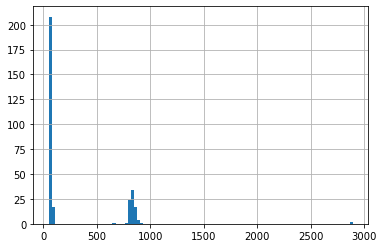

In [28]:
outliers_tavg["distance"].hist(bins = 100)

In [29]:
outliers_tavg[ outliers_tavg["distance"] > 500][ ["state_gazeeter", "state_station"] ].value_counts()

state_gazeeter            state_station
Puerto Rico               FL               78
Virgin Islands            FL                3
Northern Mariana Islands  HI                2
Alaska                    AK                1
dtype: int64

In [30]:
outliers_tavg[ outliers_tavg["distance"] <= 500][ ["state_gazeeter", "state_station"] ].value_counts()

state_gazeeter  state_station
Texas           TX               30
Kansas          KS               18
Iowa            IA               13
Illinois        IL               10
Minnesota       MN               10
Nebraska        NE                9
South Dakota    SD                8
Louisiana       LA                8
Illinois        IN                7
Arkansas        AR                6
Oklahoma        OK                6
Minnesota       SD                6
New York        NY                5
Pennsylvania    PA                5
New Mexico      NM                5
Indiana         IN                4
Michigan        MI                4
Wisconsin       WI                4
Florida         FL                3
Alaska          AK                3
Louisiana       MS                3
Maine           ME                3
Colorado        CO                3
Missouri        MO                3
West Virginia   WV                3
Illinois        MO                2
Iowa            SD                

In [110]:
for k, v in closest_stations_allinfo.items():
    ddiff = v[ v["state_gazeeter"] != v["state_station"]][ ["state_gazeeter", "state_station"]]
    print(k, len(ddiff ), len(v) )
    print( ddiff.value_counts() )

PRCP 69 3221
state_gazeeter  state_station
KY              TN               7
TX              OK               3
OK              KS               3
WV              OH               2
GA              AL               2
IN              KY               2
LA              MS               2
OK              AR               2
MO              AR               2
KY              IN               2
AR              MS               2
TX              LA               2
IL              MO               2
                KY               1
KY              OH               1
                IL               1
KS              NE               1
GA              TN               1
IL              IN               1
ID              OR               1
IA              MN               1
GA              FL               1
FL              AL               1
DC              VA               1
AZ              CA               1
AL              MS               1
KY              VA               1
MN          

In [103]:
closest_stations_allinfo["PRCP"]

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
0,1001,Autauga County,AL,USC00010823,BILLINGSLEY,AL,32.6625,-86.7244,8.110800
1,1003,Baldwin County,AL,US1ALBW0079,DAPHNE 4.9 SE,AL,30.5724,-87.8444,6.740569
2,1005,Barbour County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,8.469317
3,1011,Bullock County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,13.711696
4,1109,Pike County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,17.527742
...,...,...,...,...,...,...,...,...,...
3216,72129,San Lorenzo Municipio,PR,RQ1PRJN0001,JUNCOS 0.3 WSW,PR,18.2228,-65.9161,5.270352
3217,72151,Yabucoa Municipio,PR,RQ1PRJN0001,JUNCOS 0.3 WSW,PR,18.2228,-65.9161,9.533835
3218,72097,Mayagüez Municipio,PR,RQ1PRRN0003,RINCON 1.5 N,PR,18.3627,-67.2497,37.022483
3219,72117,Rincón Municipio,PR,RQ1PRRN0003,RINCON 1.5 N,PR,18.3627,-67.2497,1.319982


# Filter out wrongly matched fips

In [113]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 100 ][ ["state_gazeeter", "state_station"]].value_counts()

state_gazeeter  state_station
PR              FL               234
AK              AK                20
LA              MS                 6
HI              AK                 6
                CA                 4
LA              LA                 3
ME              ME                 1
LA              TX                 1
                AL                 1
AZ              NM                 1
dtype: int64

In [114]:
dfmi_closest_stations[ (dfmi_closest_stations["distance"] > 100 )  & (dfmi_closest_stations["state_gazeeter"] == "AK")]

fips                      county state_gazeeter   station_id  \
SNOW 93   2013      Aleutians East Borough             AK  USC00502587   
     94   2016  Aleutians West Census Area             AK  USC00502587   
     99   2050          Bethel Census Area             AK  USC00507570   
     100  2060         Bristol Bay Borough             AK  USC00507570   
     101  2070      Dillingham Census Area             AK  USC00507570   
     102  2150       Kodiak Island Borough             AK  USC00507570   
     103  2158        Kusilvak Census Area             AK  USC00507570   
     104  2164  Lake and Peninsula Borough             AK  USC00507570   
     116  2180            Nome Census Area             AK  USW00026529   
     117  2188    Northwest Arctic Borough             AK  USW00026529   
     125  2282    Yakutat City and Borough             AK  USC00503504   
SNWD 89   2013      Aleutians East Borough             AK  USC00502587   
     90   2016  Aleutians West Census Area             AK  USC00502587   
     95   2050          Bethel Census Area             AK  USC00507570   
     97   2070      Dillingham Census Area             AK  USS0054K01S   
     110  2158        Kusilvak Census Area             AK  USS0064P01S   
PRCP 76   2016  Aleutians West Census Area             AK  USW00025711   
TMAX 78   2016  Aleutians West Census Area             AK  USW00025711   
TMIN 78   2016  Aleutians West Census Area             AK  USW00025711   
TAVG 112  2016  Aleutians West Census Area             AK  USW00025624   

                                          station_name state_station  \
SNOW 93   DUTCH HARBOR                                            AK   
     94   DUTCH HARBOR                                            AK   
     99   PORT ALSWORTH                                           AK   
     100  PORT ALSWORTH                                           AK   
     101  PORT ALSWORTH                                           AK   
     102  PORT ALSWORTH                                           AK   
     103  PORT ALSWORTH                                           AK   
     104  PORT ALSWORTH                                           AK   
     116  TANANA CALHOUN MEM AP                  70178            AK   
     117  TANANA CALHOUN MEM AP                  70178            AK   
     125  HAINES 40NW                                             AK   
SNWD 89   DUTCH HARBOR                                            AK   
     90   DUTCH HARBOR                                            AK   
     95   PORT ALSWORTH                                           AK   
     97   Mcneil River SGS                                        AK   
     110  Johnson's Camp                                          AK   
PRCP 76   ST. PAUL 4 NE                          70309            AK   
TMAX 78   ST. PAUL 4 NE                          70309            AK   
TMIN 78   ST. PAUL 4 NE                          70309            AK   
TAVG 112  COLD BAY AP                    GSN     70316            AK   

          latitude_station  longitude_station    distance  
SNOW 93            53.8950          -166.5433  164.577009  
     94            53.8950          -166.5433  516.924429  
     99            60.2036          -154.3164  164.415750  
     100           60.2036          -154.3164  110.477210  
     101           60.2036          -154.3164  116.174869  
     102           60.2036          -154.3164  139.416398  
     103           60.2036          -154.3164  263.729291  
     104           60.2036          -154.3164  130.908558  
     116           65.1744          -152.1069  284.497727  
     117           65.1744          -152.1069  205.127868  
     125           59.4503          -136.3614  117.916667  
SNWD 89            53.8950          -166.5433  164.577009  
     90            53.8950          -166.5433  516.924429  
     95            60.2036          -154.3164  164.415750  
     97            59.0800          -154.2

In [127]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 200 ][ ["state_gazeeter", "state_station"]].value_counts()

state_gazeeter  state_station
PR              FL               234
AK              AK                 9
HI              AK                 6
                CA                 4
dtype: int64

In [124]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 200 ][ ["state_gazeeter", "state_station"]].value_counts().index.values

array([('PR', 'FL'), ('AK', 'AK'), ('HI', 'AK'), ('HI', 'CA')],
      dtype=object)

In [128]:
dfmi_closest_stations[ (dfmi_closest_stations["state_gazeeter"] == "HI" ) & (dfmi_closest_stations["state_station"] == "CA")]

fips         county state_gazeeter   station_id  \
SNOW 262  15001  Hawaii County             HI  US1CASM0007   
     263  15009    Maui County             HI  US1CASM0007   
SNWD 257  15001  Hawaii County             HI  US1CASM0007   
     258  15009    Maui County             HI  US1CASM0007   

                                          station_name state_station  \
SNOW 262  HALF MOON BAY 0.5 SSW                                   CA   
     263  HALF MOON BAY 0.5 SSW                                   CA   
SNWD 257  HALF MOON BAY 0.5 SSW                                   CA   
     258  HALF MOON BAY 0.5 SSW                                   CA   

          latitude_station  longitude_station     distance  
SNOW 262            37.463          -122.4408  1880.790043  
     263            37.463          -122.4408  1883.043157  
SNWD 257            37.463          -122.4408  1880.790043  
     258            37.463          -122.4408  1883.043157

In [138]:
a =dfmi_closest_stations.xs("SNOW")
print( a[a["state_gazeeter"] == "PR"]["distance"].min() )
a[a["state_gazeeter"] == "PR"]

770.3097769505598


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
425,72001,Adjuntas Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,816.178941
426,72003,Aguada Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,791.410175
427,72005,Aguadilla Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,790.049157
428,72007,Aguas Buenas Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,841.812683
429,72009,Aibonito Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,839.538138
...,...,...,...,...,...,...,...,...,...
3216,72137,Toa Baja Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,832.876833
3217,72139,Trujillo Alto Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,844.937180
3218,72143,Vega Alta Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,827.184769
3219,72145,Vega Baja Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,823.898743


In [139]:
a =dfmi_closest_stations.xs("SNWD")
print( a[a["state_gazeeter"] == "PR"]["distance"].min() )
a[a["state_gazeeter"] == "PR"]

774.4266626683777


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
380,72021,Bayamón Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,846.445431
381,72029,Canóvanas Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,859.414382
382,72031,Carolina Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,853.722303
383,72033,Cataño Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,844.350263
384,72037,Ceiba Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,873.432979
...,...,...,...,...,...,...,...,...,...
498,72133,Santa Isabel Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,846.800189
499,72141,Utuado Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,823.702407
500,72149,Villalba Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,838.128486
501,72151,Yabucoa Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,868.517927


## Set snow and snow depth stations to NaN for Hawaii (HI) and Puerto Rico (PR)

In [187]:
print(dfmi_closest_stations.columns)
cols_to_nan = ['station_id', 'station_name','state_station', 'latitude_station', 'longitude_station', 'distance']
states_to_nan= ["HI", "PR"]
meas_to_nan = ["SNOW", "SNWD"]
# true for index where measure = SNOW or SNWD
cond_measure = dfmi_closest_stations.index.get_level_values(0).isin(meas_to_nan)
# true for state_station is HI or PR
cond_state = dfmi_closest_stations["state_gazeeter"].isin (states_to_nan)
# set rows where both conditions are true to nan
#print(dfmi_closest_stations[ cond_measure & cond_state])
dfmi_closest_stations.loc[ cond_measure & cond_state, cols_to_nan] = np.nan

Index(['fips', 'county', 'state_gazeeter', 'station_id', 'station_name',
       'state_station', 'latitude_station', 'longitude_station', 'distance'],
      dtype='object')


In [186]:
 dfmi_closest_stations.loc[cond_measure & cond_state] 


fips                  county state_gazeeter station_id  \
SNOW 95   15003         Honolulu County             HI        NaN   
     96   15005          Kalawao County             HI        NaN   
     97   15007            Kauai County             HI        NaN   
     262  15001           Hawaii County             HI        NaN   
     263  15009             Maui County             HI        NaN   
...         ...                     ...            ...        ...   
SNWD 498  72133  Santa Isabel Municipio             PR        NaN   
     499  72141        Utuado Municipio             PR        NaN   
     500  72149      Villalba Municipio             PR        NaN   
     501  72151       Yabucoa Municipio             PR        NaN   
     502  72153         Yauco Municipio             PR        NaN   

         station_name state_station  latitude_station  longitude_station  \
SNOW 95           NaN           NaN               NaN                NaN   
     96           NaN           NaN               NaN                NaN   
     97           NaN           NaN               NaN                NaN   
     262          NaN           NaN               NaN                NaN   
     263          NaN           NaN               NaN                NaN   
...               ...           ...               ...                ...   
SNWD 498          NaN           NaN               NaN                NaN   
     499          NaN           NaN               NaN                NaN   
     500          NaN           NaN               NaN                NaN   
     501          NaN           NaN               NaN                NaN   
     502          NaN           NaN               NaN                NaN   

          distance  
SNOW 95        NaN  
     96        NaN  
     97        NaN  
     262       NaN  
     263       NaN  
...            ...  
SNWD 498       NaN  
     499       NaN  
     500       NaN  
     501       NaN  
     502       NaN  

[166 rows x 9 columns]